# Example 1D: Ornstein-Uhlenbeck system

### Load basic modules.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

### Add the (custom) source code file in the path.

In [2]:
module_path = os.path.abspath(os.path.join('../src/'))

if module_path not in sys.path:
    sys.path.append(module_path)
# _end_if_

### Load custom modules.

In [3]:
from var_bayes.free_energy import FreeEnergy
from dynamical_systems.ornstein_uhlenbeck import OrnsteinUhlenbeck
from numerical.symbolics import get_local_polynomials

### Create a dynamic system object with fixed random seed.

In [4]:
# Drift and noise parameters.
theta = np.array([2.0, 0.0])
sigma = 1.0

# Create a OU object.
OU = OrnsteinUhlenbeck(sigma, theta, r_seed=575)

### Setup trajectory and observations settings.

In [5]:
# Time-window of inference T = [t0, tf] with step = dt.
t0, tf, dt = 0.0, 10.0, 0.001

# Make a trajectory (discrete sample path).
OU.make_trajectory(t0, tf, dt)

# Observation density.
nobs_per_time_unit = 2

# Collect the noise free observations.
obs_idk, obs_val = OU.collect_obs(nobs_per_time_unit)

# Observation noise (variance).
obs_noise = 0.04

# Add Gaussian I.I.D. noise to the observations.
obs_val += np.sqrt(obs_noise) * OU.rng.standard_normal(obs_val.shape)

### Plot the "true" trajectory.

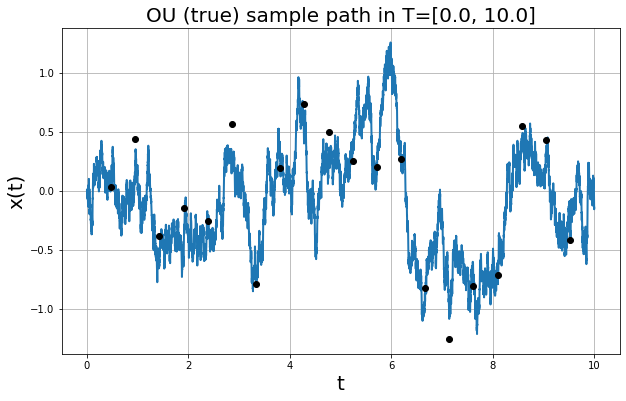

In [6]:
# Create one subplot.
_, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Plot the initial path.
ax1.plot(OU.tk, OU.xt, linewidth=2)
ax1.plot(obs_idk*dt, obs_val, 'ko')

# Plot the x/y labels.
ax1.set_xlabel('t', fontsize=20)
ax1.set_ylabel("x(t)", fontsize=20)

# Set the title.
ax1.set_title(f"OU (true) sample path in T=[{t0}, {tf}]", fontsize=20)
ax1.grid(True)

### Create the initial path $\bf{x}_0$ to start the optimization.

Note: If it happens to have observations at the initial and final

times (i.e. t0, tf), then we do not need to extend the following

vectors "spl_timex" and "spl_value".

In [7]:
# Build the splines with these parameters.
spl_timex = np.array([t0,
                      *(obs_idk*dt),
                      tf])

spl_value = np.array([obs_val[0],
                      *obs_val,
                      obs_val[-1]])

# Create the initial sample path (t=0) using
# cubic B-splines at the noisy observations.
B_spline_cubic = splrep(spl_timex, spl_value, k=3)

# Evaluate the B-spline at the whole time-window 'tk'.
x0 = splev(OU.tk, B_spline_cubic)

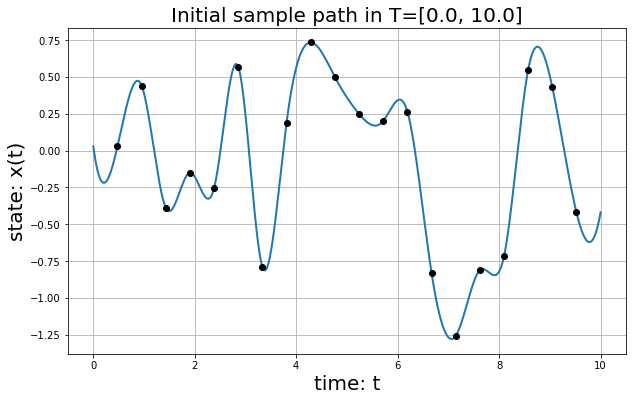

In [8]:
# Create one subplot.
_, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Plot the initial path.
ax1.plot(OU.tk, x0, linewidth=2)
ax1.plot(obs_idk*dt, obs_val, 'ko')

# Plot the x/y labels.
ax1.set_xlabel("time: t", fontsize=20)
ax1.set_ylabel("state: x(t)", fontsize=20)

# Set the title.
ax1.set_title(f"Initial sample path in T=[{t0}, {tf}]", fontsize=20)
ax1.grid(True)

### Create the time indexes at the observation times.

In [9]:
# This time space is in index-units.
time_space = [0, *obs_idk, len(x0)-1]

mp_idk = []
sp_idk = []

for n, tn in enumerate(time_space):
    
    # Avoids out of bounds.
    if tn == time_space[-1]:
        break
    # _end_if_
    
    # Take every 4 instances.
    mp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=4, endpoint=True, dtype=int))
    
    # Take every 3 instances.
    sp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=3, endpoint=True, dtype=int))
# _end_for_

# Remove the duplicates (at observation points).
mp_idk = np.unique(mp_idk)
sp_idk = np.unique(sp_idk)

### Extract the initial mean and variance points for the optimization.

In [10]:
# Initial mean points are taken from the x0.
mp_t0 = x0[mp_idk]

# Initialize variance points with constant values.
sp_t0 =  0.2 * np.ones(len(sp_idk))

# Perturb with some positive noise.
sp_t0 += 0.1 * np.random.rand(*sp_t0.shape)

# Put the variance in log-space.
sp_t0 = np.log(sp_t0)

### Initial setup for the FreeEnergy object.

In [11]:
# Initial prior moments for N(mu0, tau0).
mu0, tau0 = 1.0, 0.2

# Create a FreeEnergy object.
free_energy = FreeEnergy(OU, mu0, tau0, obs_idk*dt, obs_val, obs_noise)

## Free energy minimization.

The *gradients-check* can be very time consuming for high dimensional systems

but it is good to run it at least once to make sure that the analytic gradients

that we have computed match the numerical ones.

In [12]:
# Run the optimization.
opt_res = free_energy.find_minimum(np.concatenate((mp_t0.flatten(order='C'),
                                                   sp_t0.flatten(order='C')), axis=0),
                                   maxiter=500, check_gradients=True, verbose=True)

Grad-Check |BEFORE| minimization ...
 > Error = 5.265E-06
------------------------------------

SCG: Optimization started ...
It=     0: F(x)= 4.981E+01 -:- Sum(|Gradients|)= 1.323E+02 -:- Delta(Elapsed)= 0.21 sec.
It=    50: F(x)= 1.489E+01 -:- Sum(|Gradients|)= 1.374E+00 -:- Delta(Elapsed)= 21.90 sec.
It=   100: F(x)= 1.488E+01 -:- Sum(|Gradients|)= 3.581E-01 -:- Delta(Elapsed)= 24.31 sec.
It=   150: F(x)= 1.487E+01 -:- Sum(|Gradients|)= 3.691E-02 -:- Delta(Elapsed)= 24.46 sec.
It=   200: F(x)= 1.487E+01 -:- Sum(|Gradients|)= 3.152E-02 -:- Delta(Elapsed)= 25.32 sec.
It=   250: F(x)= 1.487E+01 -:- Sum(|Gradients|)= 8.601E-02 -:- Delta(Elapsed)= 24.40 sec.
It=   300: F(x)= 1.487E+01 -:- Sum(|Gradients|)= 1.538E-02 -:- Delta(Elapsed)= 24.42 sec.
Elapsed time [336]: 160.74 seconds.

Grad-Check |AFTER| minimization ...
 > Error = 1.766E-06
------------------------------------

Done!


In [13]:
# Unpack the optimization results.
opt_x, opt_fx, opt_stats = opt_res

# Get the mean points.
mp_tf = opt_x[0:mp_t0.size]

# Get the variance points. Remember that they
# are in log-space so here we have to use exp().
sp_tf = np.exp(opt_x[mp_t0.size:])

## Plots:

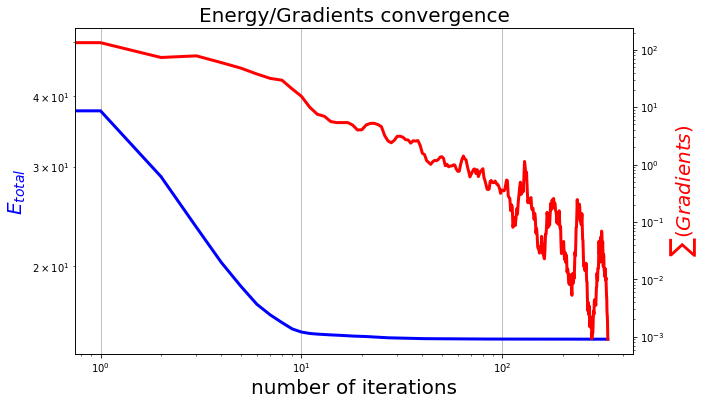

In [14]:
# Make a single plot.
_, ax1 = plt.subplots(1, figsize=(10, 6))

# Plot the energy values.
ax1.loglog(opt_stats["fx"][0:opt_stats["nit"]], color='b', linewidth=3)
ax1.set_title("Energy/Gradients convergence", fontsize=20)
ax1.set_xlabel("number of iterations", fontsize=20)
ax1.set_ylabel("$E_{total}$", color='b', fontsize=20)

# Define second y-axis that shares x-axis with current plot.
ax2 = ax1.twinx()
ax2.loglog(opt_stats["dfx"][0:opt_stats["nit"]], color='r', linewidth=3)
ax2.set_ylabel("$\sum (Gradients) $", color='r', fontsize=20)

# Plot the grid.
ax1.grid(True)

### Create the m(t) and s(t)

**Note**: since the results are in the form of Lagrange polynomials, there is no _time discretization_.

So, we can generate as many point as we want between two subsequent observation times.

In [15]:
# Get the lambda functions of the polynomials.
poly_mean, poly_vars = get_local_polynomials()

In [16]:
# Empty lists for the output functions.
tt, mt, st = [], [], []

# This time space is in time-units.
Tx = [t0, *(dt*obs_idk), tf]

# Reconstruct the mean and variance functions.
for n in range(0, len(Tx)-1):
    
    # Take the limits of the time interval.
    ti, tj = Tx[n], Tx[n+1]
        
    # It should be the same for equally spaced oservations.
    delta_t = np.abs(tj-ti)
    
    # Spacing variables for the polynomials.
    h = float(delta_t/3.0)
    c = float(delta_t/2.0)
    
    # Extract variables for efficiency.
    nth_mean_points = mp_tf[(3 * n): (3 * n) + 4]
    nth_vars_points = sp_tf[(2 * n): (2 * n) + 3]
    
    # Prepare the parameters of the Lagrange polynomials.
    par_m = [ti, ti + h, ti + (2 * h), ti + (3 * h), *nth_mean_points]
    par_s = [ti, ti + c, ti + (2 * c), *nth_vars_points]
    
    # Since the functions are continous we can generate
    # as many m(t) and s(t) as we want. Here we collect
    # num points.
    for t in np.linspace(ti, tj, num=100, endpoint=False):
        
        mt.append(poly_mean(t, *par_m))
        st.append(poly_vars(t, *par_s))
        tt.append(t)
        
    # _end_for_
    
# _end_for_

# Add the final point 'tf'.
mt.append(poly_mean(tf, *par_m))
st.append(poly_vars(tf, *par_s))
tt.append(tf)

In [17]:
# Convert everything to numpy arrays.
tt = np.array(tt)
mt = np.array(mt)
st = np.array(st)

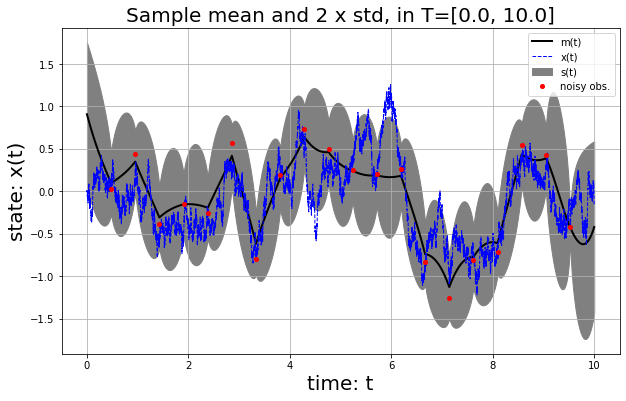

In [18]:
# Create one subplot.
_, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Sample mean.
ax1.plot(tt, mt, 'k-', label="m(t)", linewidth=2)

# Plot the true sample path.
ax1.plot(OU.tk, OU.xt, 'b--', label="x(t)", linewidth=1)

# Sample 2xStd (filled envelope).
ax1.fill_between(tt, mt - 2.0*np.sqrt(st), mt + 2.0*np.sqrt(st),
                 label="s(t)", color="gray")

# Noisy observations.
ax1.plot(obs_idk*dt, obs_val, 'ro',
         markersize=4, label="noisy obs.")

# Plot the x/y labels.
ax1.set_xlabel("time: t", fontsize=20)
ax1.set_ylabel("state: x(t)", fontsize=20)

# Set the title.
ax1.set_title(f"Sample mean and 2 x std, in T=[{t0}, {tf}]", fontsize=20)
ax1.grid(True)

# Set the legend.
ax1.legend(loc="best");

## End of notebook